In [1]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Conv2D
from tensorflow.keras import optimizers

import os
import shutil
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-3/tiny_image_net.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/tiny-imagenet-200/val/images/val_5500.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5501.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5502.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5503.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5504.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5505.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5506.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5507.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5508.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5509.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_551.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5510.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5511.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5512.JPEG  
  inflating:

In [ ]:
image_size = 64
base_folder = '/content/tiny-imagenet-200/'
def read_images(folder, test=False):
    imgs = np.zeros((0, image_size, image_size, 3))
    image_count = 0
    for filename in os.listdir(folder):
        #print(filename)
        img = plt.imread(os.path.join(folder,filename))
        img = resize(img, (64,64,3), preserve_range=True)
        if img is not None:
            imgs = np.concatenate([imgs, np.expand_dims(img, 0)], 0)
            image_count += 1
        if test == True:
          print(image_count)
        if image_count == 300:
          if test == False:
            break
    return imgs

def get_y(val_x_path, label_map):
    y_labels = []
    imageName_class_map = {}
    annonate_file = open(val_x_path+'/val_annotations.txt', "r", encoding="utf8")

    for l in annonate_file:
      words = l.split()
      imageName_class_map[words[0]] = words[1]

    for i, dir in enumerate(os.listdir(val_x_path+'/images')):
        '''
        #print(dir)
        #print(label_map[imageName_class_map[dir]])

        if i == 10:
          break
        '''
        y_labels.append(label_map[imageName_class_map[dir]])
    print(y_labels)
    return np.array(y_labels)

def read_train_images(directory_name='train'):
    images = np.zeros((0,image_size,image_size,3))
    labels = np.zeros((0))
    label_mapping = {}
    
    for i, dir in enumerate(os.listdir(directory_name)):
        print(directory_name)
        label_mapping[dir] = i
        print(i)
        
        imgs = read_images(directory_name+'/'+dir+'/images/', test=False)
        images = np.concatenate([images, imgs], 0)
        labels = np.concatenate([labels,  i*np.ones((imgs.shape[0]))])

    print(images.shape, labels.shape)
    return images, labels, label_mapping


def read_test_images(directory_name='test'):
    images = np.zeros((0,image_size,image_size,3))

    print(directory_name)
    imgs = read_images(directory_name, test=True)
    images = np.concatenate([images, imgs], 0)

    print(images.shape)
    return images
            
#X_train, Y_train, label_map = read_train_images(directory_name = base_folder+'train')



In [4]:
image_class_map = {}
images_path = '/content/tiny-imagenet-200/tiny-imagenet-200/val/'
annotate_file = open(images_path+'val_annotations.txt')

for l in annotate_file:
    words = l.split()
    image_class_map[words[0]] = words[1]
len(image_class_map)

10000

In [5]:
if os.path.isdir(images_path+'val_images/') == False:
  os.mkdir(images_path+'val_images/')

for i, image in enumerate(os.listdir(images_path+'images/')):
    class_name = image_class_map[image]

    source = images_path+'images/'+image
    dest = images_path+'val_images/'+class_name
    
    if os.path.isdir(dest) == False:
        os.mkdir(dest)
    
    shutil.copy(source, dest)
for dir in os.listdir(images_path+'val_images/'):
  if len([name for name in os.listdir(images_path+'val_images/'+dir)]) != 50:
    print(dir)

In [6]:
# testing dataflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_folder = '/content/tiny-imagenet-200/tiny-imagenet-200/'
train_dir = base_folder + 'train'
val_dir = base_folder + 'val/val_images'

image_size = 64
train_batchSize = 64
val_batchSize = 64

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   #rotation_range=15,
                                   #fill_mode='linear',
                                   horizontal_flip=True,
                                   preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

validation_datagen = ImageDataGenerator(rescale=1/255.)

train_gen = train_datagen.flow_from_directory(train_dir,
                                               target_size=(image_size,image_size),
                                               batch_size=train_batchSize,
                                               class_mode='categorical',
                                               shuffle=True)

validation_gen = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchSize,
        class_mode='categorical',
        shuffle=False)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [34]:
image = train_gen.next()
np.max(image[0])

1.0

In [ ]:
X_train.shape

(60000, 64, 64, 3)

In [ ]:
X_val = read_test_images(directory_name = base_folder+'val/images')
Y_val = get_y(base_folder+'val', label_map)

In [ ]:
#Normalize data
X_train = X_train/255. 
X_val = X_val/255.

#categorical vector will be used in ensemble 
y_train = np.copy(Y_train)
y_val = np.copy(Y_val)

y_train = y_train.reshape(y_train.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

#one hot encode for feeding to DNN
Y_val = tf.one_hot(Y_val, depth=200)
Y_train = tf.one_hot(Y_train, depth=200)


In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((400, 64, 64, 3), (400, 1), (10, 64, 64, 3), (10, 1))

In [ ]:
y_train

# New Section

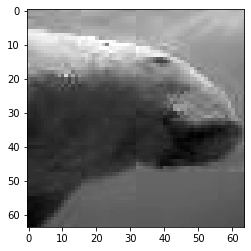

In [ ]:
plt.imshow(X_val[1,:,:,1], cmap='gray')

In [7]:
#Load the resnet model
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
#ResNet50_model.summary()

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
def pretrain_model():
  # Freeze the layers except the last 2 layers
  
  for layer in ResNet50_model.layers[:-2]:
      layer.trainable = False

  model = tf.keras.models.Sequential()
 
  # Add the resnet50 convolutional base model
  model.add(ResNet50_model)
  
  # Add 2 new layers
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(200, activation='softmax'))
  #model.summary()

  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=1e-4),
                metrics=['acc'])
  return model

In [49]:
pre_trained_model = pretrain_model()
#history = pre_trained_model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=100)

history = pre_trained_model.fit(
      train_gen,
      steps_per_epoch=train_gen.samples/train_gen.batch_size ,
      epochs=50,
      validation_data=validation_gen,
      validation_steps=validation_gen.samples/validation_gen.batch_size,
      verbose=1)

Epoch 1/50
1562/1562 [==============================] - 173s 108ms/step - loss: 2.1908 - acc: 0.5470 - val_loss: 2.1829 - val_acc: 0.4900
Epoch 2/50
1562/1562 [==============================] - 166s 106ms/step - loss: 0.7726 - acc: 0.8124 - val_loss: 2.1954 - val_acc: 0.5168
Epoch 3/50
1562/1562 [==============================] - 165s 105ms/step - loss: 0.5244 - acc: 0.8659 - val_loss: 2.2986 - val_acc: 0.5228
Epoch 4/50
1562/1562 [==============================] - 167s 107ms/step - loss: 0.4080 - acc: 0.8912 - val_loss: 2.4016 - val_acc: 0.5253
Epoch 5/50
1562/1562 [==============================] - 166s 106ms/step - loss: 0.3349 - acc: 0.9107 - val_loss: 2.5095 - val_acc: 0.5258
Epoch 6/50
1562/1562 [==============================] - 164s 105ms/step - loss: 0.2918 - acc: 0.9197 - val_loss: 2.6236 - val_acc: 0.5263
Epoch 7/50
1562/1562 [==============================] - 165s 105ms/step - loss: 0.2629 - acc: 0.9281 - val_loss: 2.7083 - val_acc: 0.5271
Epoch 8/50
1562/1562 [============

In [ ]:
pre_trained_model.save('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-3/'+'preTrained_Resnet50.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


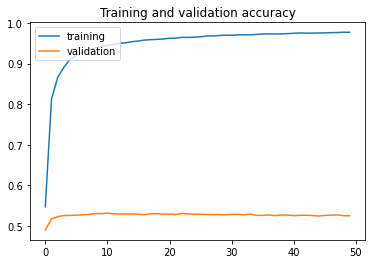

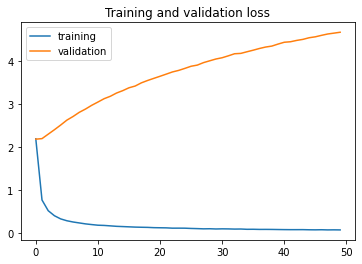

In [50]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()

In [61]:
out_file = open('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-3/pretrained_log.txt', 'w')
for l in history.history:
  print(history.history[l])
  out_file.write('\n'+l+': \n')
  out_file.write(str(history.history[l]))
out_file.close()

[2.1907894611358643, 0.7725922465324402, 0.5243969559669495, 0.4079801142215729, 0.33487075567245483, 0.29176321625709534, 0.2628929615020752, 0.24094870686531067, 0.21907590329647064, 0.20307961106300354, 0.18833184242248535, 0.18316642940044403, 0.17302122712135315, 0.16244016587734222, 0.15664485096931458, 0.15057168900966644, 0.1443575918674469, 0.14085569977760315, 0.13798849284648895, 0.1316014677286148, 0.12916377186775208, 0.12689389288425446, 0.11967290192842484, 0.12012475728988647, 0.11928456276655197, 0.1132819652557373, 0.10926615446805954, 0.10421667248010635, 0.10638061165809631, 0.10109592974185944, 0.10410742461681366, 0.10247237980365753, 0.09843525290489197, 0.09996135532855988, 0.09335466474294662, 0.09420716017484665, 0.09090432524681091, 0.09136180579662323, 0.09035300463438034, 0.08808904141187668, 0.08628372102975845, 0.0850469172000885, 0.08515900373458862, 0.08567484468221664, 0.08242976665496826, 0.08107426017522812, 0.08333835005760193, 0.07962281256914139, 

**Fine Tune Resnet50**

In [27]:
#Load the resnet model
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
#ResNet50_model.summary()

In [28]:
for layer in ResNet50_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
      print(layer)

In [11]:
def tune_model():

  for layer in ResNet50_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
      layer.trainable = True
    else:
      layer.trainable = False
  '''
  tuned_model = tf.keras.models.Sequential()

  # Add the resnet50 convolutional base model
  tuned_model.add(ResNet50_model)
  

  # Add new layers
  tuned_model.add(GlobalAveragePooling2D())
  tuned_model.add(tf.keras.layers.Flatten())
  tuned_model.add(tf.keras.layers.Dense(256, activation='relu'))
  tuned_model.add(tf.keras.layers.Dense(128, activation='relu'))
  
  tuned_model.add(tf.keras.layers.Dense(1024, activation='relu'))
  #tuned_model.add(tf.keras.layers.Dropout(.2))
  tuned_model.add(tf.keras.layers.Dense(train_gen.num_classes, activation='softmax'))
  '''
  
  # add a Conv2D layer
  x = ResNet50_model.output
  x = Conv2D(32, kernel_size= (3,3), strides = 1, padding='same', data_format='channels_first')(x)
  x = Activation('relu')(x)
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.2)(x)
  # let's add a fully-connected layer
  x = Dense(1024, activation='relu')(x)
  # and a logistic layer -- let's say we have 200 classes
  predictions = Dense(200, activation='softmax')(x)

  # this is the model we will train
  model = tf.keras.models.Model(inputs=ResNet50_model.input, outputs=predictions)

  # compile the model (should be done *after* setting layers to non-trainable)
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=1e-4),
                metrics=['acc'])

  return model

In [ ]:
'''
Epoch 1/100
390/390 [==============================] - 126s 314ms/step - loss: 5.0252 - acc: 0.0340 - val_loss: 4.8304 - val_acc: 0.0518
Epoch 2/100
390/390 [==============================] - 122s 312ms/step - loss: 4.7891 - acc: 0.0546 - val_loss: 4.7194 - val_acc: 0.0609
Epoch 3/100
390/390 [==============================] - 122s 312ms/step - loss: 4.6977 - acc: 0.0647 - val_loss: 4.6581 - val_acc: 0.0698
'''

In [10]:
fine_tuned_model = tune_model()
#history = fine_tuned_model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=100)

history = fine_tuned_model.fit(
      train_gen,
      #steps_per_epoch=train_gen.samples/train_gen.batch_size ,
      epochs=50,
      validation_data=validation_gen,
      #validation_steps=validation_gen.samples/validation_gen.batch_size,
      verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
1563/1563 [==============================] - 157s 88ms/step - loss: 5.2824 - acc: 0.0089 - val_loss: 5.2184 - val_acc: 0.0233
Epoch 2/10
 228/1563 [===>..........................] - ETA: 1:54 - loss: 5.2186 - acc: 0.0158

KeyboardInterrupt: ignored

In [44]:
fine_tuned_model.save('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignment-3/'+'tuned_Resnet50_updated.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


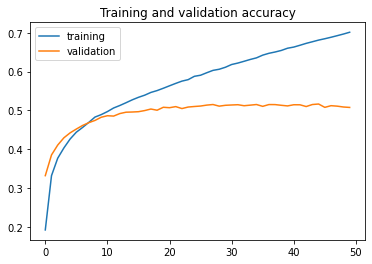

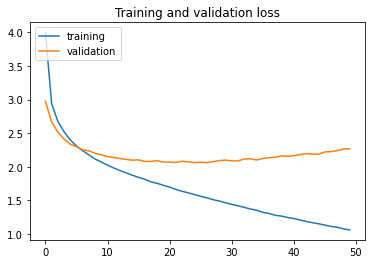

In [45]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2570      
Total params: 27,916,426
Trainable params: 5,383,434
Non-trainable params: 22,532,992
__________________________________

**Cifer10 model (pretrained)**

In [14]:
cifer10_model = tf.keras.models.load_model('/content/drive/Othercomputers/New Laptop (UofM)/Documents/Fall 2021/Neural Network/Assignments/Assignmet-2/cifer10_model_.h5')
cifer10_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)       

In [13]:
def pretrain_cifer10_model():
  # Freeze the layers except the last 2 layers
  for layer in cifer10_model.layers[:-2]:
      layer.trainable = False

  model = tf.keras.models.Sequential()
 
  # Add the resnet50 convolutional base model
  model.add(cifer10_model)
  
  # Add 2 new layers
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(200, activation='softmax'))
  #model.summary()

  # Compile the model
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(learning_rate=1e-4),
                metrics=['acc'])
  return model

In [48]:
cifer10_pretrained = pretrain_cifer10_model()
#history = fine_tuned_model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), batch_size=128, epochs=100)

history = cifer10_pretrained.fit(
      train_gen,
      #steps_per_epoch=train_gen.samples/train_gen.batch_size ,
      epochs=50,
      validation_data=validation_gen,
      #validation_steps=validation_gen.samples/validation_gen.batch_size,
      verbose=1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
221/782 [=======>......................] - ETA: 1:25 - loss: 5.3000 - acc: 0.0066

KeyboardInterrupt: ignored

**Ensemble model**

In [15]:

x_t, y_t = zip(*(train_gen[i] for i in range(len(train_gen))))
x_train = np.vstack(x_t)
y_train = np.vstack(y_t)
print(x_train.shape, y_train.shape)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(100000, 64, 64, 3) (100000, 200)


In [50]:
x_train.shape, y_train.shape

((100000, 64, 64, 3), (100000, 200))

In [51]:
a  = np.array(y_train)
a = np.argmax(a, axis=1)
a = a.reshape((a.shape[0], 1))
print(a, x_train.shape, len(a))
a = a.squeeze()

[[112]
 [106]
 [ 87]
 ...
 [140]
 [106]
 [  0]] (100000, 64, 64, 3) 100000


In [12]:
model1 = KerasClassifier(build_fn = pretrain_model, epochs = 50)
model2 = KerasClassifier(build_fn = tune_model, epochs = 50)
model3 = KerasClassifier(build_fn = pretrain_cifer10_model, epochs = 50)
model1._estimator_type = "classifier"
model2._estimator_type = "classifier"
model3._estimator_type = "classifier"

NameError: ignored

In [53]:
ensemble_clf = VotingClassifier(estimators=[('pretrained_model', model1), 
                                  ('finetuned_model', model2),
                                  ('pretrained_cifer10', model3)
                                   ], voting='soft')

In [55]:
est = ensemble_clf.fit(X=x_train, y=a)

Epoch 1/50
3125/3125 [==============================] - 49s 15ms/step - loss: 3.4346 - acc: 0.3834
Epoch 2/50
3125/3125 [==============================] - 46s 15ms/step - loss: 2.6541 - acc: 0.5289
Epoch 3/50
3125/3125 [==============================] - 46s 15ms/step - loss: 2.3382 - acc: 0.5857
Epoch 4/50
3125/3125 [==============================] - 46s 15ms/step - loss: 2.1043 - acc: 0.6278
Epoch 5/50
3125/3125 [==============================] - 46s 15ms/step - loss: 1.9221 - acc: 0.6616
Epoch 6/50
3125/3125 [==============================] - 46s 15ms/step - loss: 1.7750 - acc: 0.6904
Epoch 7/50
3125/3125 [==============================] - 46s 15ms/step - loss: 1.6512 - acc: 0.7135
Epoch 8/50
3125/3125 [==============================] - 46s 15ms/step - loss: 1.5455 - acc: 0.7343
Epoch 9/50
3125/3125 [==============================] - 46s 15ms/step - loss: 1.4552 - acc: 0.7522
Epoch 10/50
3125/3125 [==============================] - 46s 15ms/step - loss: 1.3737 - acc: 0.7677
Epoch 11/

InternalError: ignored

In [57]:
est

NameError: ignored

In [ ]:
models = [model, test_model]
model_input = tf.keras.Input(shape=(64, 64, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)